# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_000  O43157           16.462
Sample_036  P55774           14.315
Sample_180  P10153           16.889
Sample_020  P51884           19.299
Sample_112  P17931           15.185
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups                           
Sample_038  P68871                                      19.571
Sample_017  F2Z2C8;Q9BVH7                               12.487
Sample_122  E7EU04;F5GZ45;F5H3Z4;F5H4Z6;J3KR13;P14207   15.865
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.384
            A0A075B6Q5                 12.641
            A0A075B6R2                 13.404
            A0A075B6S5                 12.503
            A0A087WSY4                 13.927
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.045
            Q9UI40;Q9UI40-2            12.807
            Q9UIW2                     12.271
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.606
            Q9UP79                     11.069
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.917,15.050,16.842,19.863,15.922,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.703,19.067,...,15.528,15.576,13.955,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.814,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.488,17.705,17.039,15.924,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.699,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.270,15.345,17.084,18.708,14.249,19.433,11.049,11.066
Sample_207,15.739,16.877,15.469,16.898,14.844,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.222,13.729,12.623,13.391,12.678,14.735,12.909,12.833,11.781,12.826
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.480,19.067,16.127,...,15.173,13.636,13.065,12.890,13.222,11.745,13.821,12.915,12.555,13.531
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.600,13.111,13.022,12.425,12.021,14.138,13.165,13.012,12.164,12.029
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.927,12.504,12.415,14.445,13.312,12.113,12.992,12.358,13.320,13.580
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.633,12.513,11.887,11.960,13.102,11.663,12.356,12.690,12.419,12.213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.268,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 364.28it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.84it/s]

100%|██████████| 2/2 [00:00<00:00,  8.75it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.82it/s]

100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

100%|██████████| 3/3 [00:00<00:00,  6.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.12it/s]

100%|██████████| 4/4 [00:00<00:00,  4.31it/s]

100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 11.82it/s]

 80%|████████  | 4/5 [00:00<00:00,  7.08it/s]

100%|██████████| 5/5 [00:00<00:00,  6.31it/s]

100%|██████████| 5/5 [00:00<00:00,  6.83it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.78it/s]

 50%|█████     | 3/6 [00:00<00:00,  6.12it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.12it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  5.12it/s]

100%|██████████| 6/6 [00:01<00:00,  5.07it/s]

100%|██████████| 6/6 [00:01<00:00,  5.42it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 12.64it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  6.33it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  5.96it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  5.46it/s]

100%|██████████| 7/7 [00:01<00:00,  4.72it/s]

100%|██████████| 7/7 [00:01<00:00,  5.43it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.89it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.20it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.70it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.73it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.75it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.92it/s]

100%|██████████| 8/8 [00:01<00:00,  4.00it/s]

100%|██████████| 8/8 [00:01<00:00,  4.01it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.03it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.20it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.41it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.35it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.02it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.10it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.18it/s]

100%|██████████| 9/9 [00:02<00:00,  3.29it/s]

100%|██████████| 9/9 [00:02<00:00,  3.43it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 10.19it/s]

 40%|████      | 4/10 [00:00<00:00,  6.13it/s]

 50%|█████     | 5/10 [00:00<00:00,  6.11it/s]

 60%|██████    | 6/10 [00:00<00:00,  5.70it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.37it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.88it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.54it/s]

100%|██████████| 10/10 [00:02<00:00,  3.37it/s]

100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 10.47it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.12it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.77it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  5.87it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.56it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.39it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.78it/s]

 91%|█████████ | 10/11 [00:01<00:00,  6.10it/s]

100%|██████████| 11/11 [00:01<00:00,  6.34it/s]

100%|██████████| 11/11 [00:01<00:00,  6.10it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 11.04it/s]

 33%|███▎      | 4/12 [00:00<00:01,  7.45it/s]

 42%|████▏     | 5/12 [00:00<00:01,  6.47it/s]

 50%|█████     | 6/12 [00:00<00:00,  6.11it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  5.89it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  5.96it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  6.18it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  6.41it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  6.59it/s]

100%|██████████| 12/12 [00:01<00:00,  6.78it/s]

100%|██████████| 12/12 [00:01<00:00,  6.61it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01, 10.68it/s]

 31%|███       | 4/13 [00:00<00:01,  6.76it/s]

 38%|███▊      | 5/13 [00:00<00:01,  6.11it/s]

 46%|████▌     | 6/13 [00:00<00:01,  5.90it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  5.76it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  5.90it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  5.71it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  5.61it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  5.71it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  5.75it/s]

100%|██████████| 13/13 [00:02<00:00,  5.63it/s]

100%|██████████| 13/13 [00:02<00:00,  5.94it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 13.58it/s]

 29%|██▊       | 4/14 [00:00<00:01,  8.78it/s]

 36%|███▌      | 5/14 [00:00<00:01,  8.16it/s]

 43%|████▎     | 6/14 [00:00<00:01,  7.47it/s]

 50%|█████     | 7/14 [00:00<00:00,  7.06it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  6.92it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  7.16it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  6.89it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.81it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  6.10it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  6.23it/s]

100%|██████████| 14/14 [00:02<00:00,  6.47it/s]

100%|██████████| 14/14 [00:02<00:00,  6.98it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 16.96it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.47it/s]

 40%|████      | 6/15 [00:00<00:01,  8.31it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.01it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.55it/s]

 60%|██████    | 9/15 [00:01<00:00,  6.51it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  6.89it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  7.04it/s]

 80%|████████  | 12/15 [00:01<00:00,  6.83it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  7.03it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  7.19it/s]

100%|██████████| 15/15 [00:02<00:00,  6.95it/s]

100%|██████████| 15/15 [00:02<00:00,  7.39it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.041 0.017          0.832 0.274       0.137   
2             0.003 0.002      0.032 0.013          0.641 0.142       0.419   
3             0.003 0.001      0.028 0.008          0.611 0.117       0.498   
4             0.004 0.003      0.038 0.013          0.730 0.105       0.667   
5             0.003 0.000      0.044 0.017          0.744 0.079       0.726   
6             0.003 0.002      0.040 0.015          0.770 0.074       0.783   
7             0.003 0.000      0.035 0.000          0.803 0.082       0.808   
8             0.004 0.003      0.039 0.008          0.801 0.078       0.801   
9             0.004 0.003      0.039 0.012          0.804 0.081       0.805   
10            0.004 0.004      0.033 0.012          0.799 0.085       0.803   
11            0.004 0.002      0.034 0.014          0.808 0.084       0.808   
12            0.002 0.001      0.027 0.014          0.833 0.077       0.811   
13            0.002 0.000      0.021 0.004          0.836 0.079       0.816   
14            0.002 0.001      0.022 0.005          0.834 0.081       0.812   
15            0.002 0.000      0.021 0.004          0.827 0.082       0.817   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.227 0.124                  0.561 0.042        0.851   
2          0.111   0.501 0.110                  0.623 0.071        0.699   
3          0.097   0.545 0.095                  0.631 0.073        0.734   
4          0.105   0.691 0.082                  0.740 0.066        0.811   
5          0.094   0.732 0.071                  0.771 0.060        0.884   
6          0.092   0.772 0.062                  0.804 0.053        0.892   
7          0.097   0.802 0.070                  0.830 0.059        0.924   
8          0.101   0.797 0.068                  0.826 0.056        0.921   
9          0.099   0.800 0.069                  0.829 0.057        0.919   
10         0.101   0.796 0.068                  0.825 0.056        0.918   
11         0.101   0.803 0.068                  0.832 0.058        0.920   
12         0.091   0.818 0.064                  0.844 0.054        0.926   
13         0.091   0.822 0.067                  0.848 0.057        0.926   
14         0.096   0.819 0.070                  0.845 0.059        0.925   
15         0.092   0.819 0.068                  0.844 0.058        0.923   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.821 0.087        210.000 0.000  
2          0.084                  0.626 0.098        210.000 0.000  
3          0.072                  0.686 0.083        210.000 0.000  
4          0.065                  0.783 0.085        210.000 0.000  
5          0.045                  0.864 0.049        210.000 0.000  
6          0.043                  0.872 0.050        210.000 0.000  
7          0.038                  0.912 0.043        210.000 0.000  
8          0.040                  0.909 0.046        210.000 0.000  
9          0.040                  0.907 0.046        210.000 0.000  
10         0.040                  0.907 0.045        210.000 0.000  
11         0.041                  0.903 0.049        210.000 0.000  
12         0.040                  0.916 0.043        210.000 0.000  
13         0.040                  0.915 0.042        210.000 0.000  
14         0.042                  0.914 0.045        210.000 0.000  
15         0.042                  0.912 0.045 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 536.49it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 11.54it/s]

100%|██████████| 2/2 [00:00<00:00, 11.48it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 10.98it/s]

100%|██████████| 3/3 [00:00<00:00,  8.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.92it/s]

100%|██████████| 4/4 [00:00<00:00,  7.53it/s]

100%|██████████| 4/4 [00:00<00:00,  7.89it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 11.94it/s]

 80%|████████  | 4/5 [00:00<00:00,  7.74it/s]

100%|██████████| 5/5 [00:00<00:00,  7.31it/s]

100%|██████████| 5/5 [00:00<00:00,  7.75it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 12.78it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  7.76it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  7.26it/s]

100%|██████████| 6/6 [00:00<00:00,  6.98it/s]

100%|██████████| 6/6 [00:00<00:00,  7.49it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 11.33it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.94it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  5.78it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  5.59it/s]

100%|██████████| 7/7 [00:01<00:00,  5.66it/s]

100%|██████████| 7/7 [00:01<00:00,  5.96it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 11.61it/s]

 50%|█████     | 4/8 [00:00<00:00,  7.62it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  7.22it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  6.80it/s]

 88%|████████▊ | 7/8 [00:00<00:00,  6.66it/s]

100%|██████████| 8/8 [00:01<00:00,  6.46it/s]

100%|██████████| 8/8 [00:01<00:00,  6.99it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  9.50it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.89it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.87it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  5.35it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  5.00it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.82it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.78it/s]

100%|██████████| 9/9 [00:01<00:00,  4.75it/s]

100%|██████████| 9/9 [00:01<00:00,  5.23it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 10.29it/s]

 40%|████      | 4/10 [00:00<00:01,  5.70it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.40it/s]

 60%|██████    | 6/10 [00:01<00:00,  5.54it/s]

 70%|███████   | 7/10 [00:01<00:00,  5.87it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.82it/s]

 90%|█████████ | 9/10 [00:01<00:00,  6.10it/s]

100%|██████████| 10/10 [00:01<00:00,  6.39it/s]

100%|██████████| 10/10 [00:01<00:00,  6.10it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.98it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.85it/s]

 45%|████▌     | 5/11 [00:00<00:00,  7.35it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  7.29it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  7.10it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  6.74it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  6.56it/s]

 91%|█████████ | 10/11 [00:01<00:00,  6.23it/s]

100%|██████████| 11/11 [00:01<00:00,  6.57it/s]

100%|██████████| 11/11 [00:01<00:00,  7.01it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 15.95it/s]

 33%|███▎      | 4/12 [00:00<00:00,  9.74it/s]

 50%|█████     | 6/12 [00:00<00:00,  7.98it/s]

 58%|█████▊    | 7/12 [00:00<00:00,  7.53it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  7.21it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  6.83it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  6.22it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  6.30it/s]

100%|██████████| 12/12 [00:01<00:00,  6.30it/s]

100%|██████████| 12/12 [00:01<00:00,  7.14it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 15.92it/s]

 31%|███       | 4/13 [00:00<00:00, 10.55it/s]

 46%|████▌     | 6/13 [00:00<00:00,  9.49it/s]

 62%|██████▏   | 8/13 [00:00<00:00,  9.17it/s]

 69%|██████▉   | 9/13 [00:00<00:00,  9.05it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  8.89it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  8.76it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  8.72it/s]

100%|██████████| 13/13 [00:01<00:00,  8.69it/s]

100%|██████████| 13/13 [00:01<00:00,  9.21it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 15.83it/s]

 29%|██▊       | 4/14 [00:00<00:00, 10.13it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.39it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  9.07it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  8.89it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  8.75it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  8.52it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  8.36it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  8.44it/s]

100%|██████████| 14/14 [00:01<00:00,  8.51it/s]

100%|██████████| 14/14 [00:01<00:00,  8.97it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.88it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.43it/s]

 40%|████      | 6/15 [00:00<00:00,  9.51it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  9.13it/s]

 60%|██████    | 9/15 [00:00<00:00,  9.00it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.93it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.85it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.79it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.74it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.49it/s]

100%|██████████| 15/15 [00:01<00:00,  8.54it/s]

100%|██████████| 15/15 [00:01<00:00,  9.09it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.021 0.005          0.000 0.000       0.000   
2             0.002 0.000      0.020 0.003          0.708 0.091       0.602   
3             0.002 0.001      0.022 0.005          0.719 0.095       0.632   
4             0.002 0.001      0.022 0.006          0.713 0.103       0.605   
5             0.002 0.000      0.021 0.004          0.779 0.092       0.713   
6             0.002 0.001      0.023 0.005          0.789 0.087       0.727   
7             0.002 0.000      0.020 0.003          0.797 0.085       0.738   
8             0.003 0.001      0.032 0.017          0.809 0.094       0.753   
9             0.003 0.003      0.035 0.014          0.807 0.092       0.755   
10            0.002 0.000      0.021 0.003          0.791 0.102       0.770   
11            0.002 0.000      0.019 0.000          0.810 0.099       0.786   
12            0.002 0.000      0.019 0.000          0.813 0.098       0.789   
13            0.002 0.000      0.019 0.000          0.822 0.108       0.788   
14            0.002 0.000      0.019 0.000          0.829 0.104       0.796   
15            0.002 0.000      0.019 0.001          0.821 0.098       0.803   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.855   
2          0.121   0.643 0.090                  0.708 0.067        0.786   
3          0.124   0.665 0.086                  0.723 0.067        0.794   
4          0.120   0.646 0.087                  0.709 0.065        0.789   
5          0.130   0.737 0.092                  0.780 0.073        0.875   
6          0.109   0.750 0.074                  0.790 0.059        0.878   
7          0.109   0.760 0.073                  0.798 0.057        0.881   
8          0.102   0.775 0.074                  0.809 0.060        0.884   
9          0.108   0.774 0.075                  0.809 0.061        0.883   
10         0.120   0.773 0.083                  0.807 0.070        0.908   
11         0.124   0.790 0.086                  0.823 0.071        0.918   
12         0.128   0.794 0.086                  0.826 0.071        0.917   
13         0.114   0.798 0.083                  0.828 0.070        0.918   
14         0.117   0.805 0.084                  0.835 0.070        0.918   
15         0.114   0.805 0.080                  0.835 0.067        0.917   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.825 0.087        210.000 0.000  
2          0.080                  0.734 0.101        210.000 0.000  
3          0.080                  0.750 0.098        210.000 0.000  
4          0.080                  0.748 0.097        210.000 0.000  
5          0.058                  0.849 0.073        210.000 0.000  
6          0.056                  0.848 0.069        210.000 0.000  
7          0.056                  0.849 0.072        210.000 0.000  
8          0.057                  0.855 0.075        210.000 0.000  
9          0.056                  0.856 0.075        210.000 0.000  
10         0.047                  0.879 0.061        210.000 0.000  
11         0.046                  0.892 0.059        210.000 0.000  
12         0.046                  0.893 0.059        210.000 0.000  
13         0.045                  0.895 0.058        210.000 0.000  
14         0.046                  0.895 0.058        210.000 0.000  
15         0.048                  0.896 0.058 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1400.44it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 67.34it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 52.02it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 46.64it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 43.96it/s]

100%|██████████| 5/5 [00:00<00:00, 43.76it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 43.92it/s]

100%|██████████| 6/6 [00:00<00:00, 42.04it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 43.55it/s]

100%|██████████| 7/7 [00:00<00:00, 40.84it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 43.83it/s]

100%|██████████| 8/8 [00:00<00:00, 40.19it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 43.94it/s]

100%|██████████| 9/9 [00:00<00:00, 39.80it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 44.13it/s]

100%|██████████| 10/10 [00:00<00:00, 38.73it/s]

100%|██████████| 10/10 [00:00<00:00, 39.38it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 44.24it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.64it/s]

100%|██████████| 11/11 [00:00<00:00, 38.92it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 44.12it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 38.71it/s]

100%|██████████| 12/12 [00:00<00:00, 38.62it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 43.92it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.50it/s]

100%|██████████| 13/13 [00:00<00:00, 38.24it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 44.22it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 38.33it/s]

100%|██████████| 14/14 [00:00<00:00, 36.98it/s]

100%|██████████| 14/14 [00:00<00:00, 37.83it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 43.93it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 38.48it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 37.17it/s]

100%|██████████| 15/15 [00:00<00:00, 37.75it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.019 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.019 0.000          0.402 0.405       0.053   
3             0.002 0.000      0.019 0.000          0.442 0.214       0.136   
4             0.002 0.000      0.019 0.000          0.665 0.116       0.550   
5             0.002 0.000      0.019 0.000          0.679 0.108       0.607   
6             0.002 0.000      0.019 0.000          0.670 0.110       0.630   
7             0.002 0.000      0.019 0.000          0.673 0.108       0.631   
8             0.002 0.000      0.019 0.000          0.668 0.095       0.628   
9             0.002 0.000      0.019 0.000          0.667 0.100       0.628   
10            0.002 0.000      0.020 0.000          0.684 0.094       0.647   
11            0.002 0.000      0.021 0.003          0.682 0.097       0.643   
12            0.002 0.000      0.020 0.000          0.677 0.097       0.630   
13            0.002 0.000      0.020 0.000          0.682 0.083       0.633   
14            0.002 0.000      0.020 0.000          0.668 0.082       0.624   
15            0.002 0.000      0.020 0.000          0.669 0.084       0.617   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.730   
2          0.061   0.090 0.097                  0.507 0.035        0.601   
3          0.079   0.199 0.101                  0.502 0.047        0.574   
4          0.126   0.596 0.112                  0.674 0.076        0.759   
5          0.119   0.636 0.099                  0.698 0.077        0.773   
6          0.117   0.644 0.096                  0.699 0.079        0.777   
7          0.116   0.646 0.097                  0.701 0.079        0.776   
8          0.111   0.642 0.090                  0.699 0.072        0.805   
9          0.110   0.641 0.089                  0.697 0.072        0.802   
10         0.118   0.659 0.087                  0.713 0.070        0.804   
11         0.119   0.656 0.090                  0.710 0.072        0.800   
12         0.112   0.648 0.090                  0.704 0.072        0.804   
13         0.109   0.652 0.080                  0.708 0.063        0.802   
14         0.118   0.640 0.085                  0.699 0.064        0.800   
15         0.118   0.636 0.086                  0.697 0.064        0.799   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.688 0.084        210.000 0.000  
2          0.083                  0.555 0.098        210.000 0.000  
3          0.072                  0.510 0.072        210.000 0.000  
4          0.079                  0.701 0.082        210.000 0.000  
5          0.080                  0.727 0.088        210.000 0.000  
6          0.081                  0.743 0.086        210.000 0.000  
7          0.081                  0.742 0.085        210.000 0.000  
8          0.066                  0.768 0.076        210.000 0.000  
9          0.068                  0.766 0.077        210.000 0.000  
10         0.067                  0.764 0.076        210.000 0.000  
11         0.066                  0.759 0.076        210.000 0.000  
12         0.068                  0.761 0.082        210.000 0.000  
13         0.065                  0.756 0.079        210.000 0.000  
14         0.066                  0.750 0.082        210.000 0.000  
15         0.067                  0.751 0.082 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,9,9,11
score_time,5,9,11
test_precision,13,14,10
test_recall,15,15,10
test_f1,13,15,10
test_balanced_accuracy,13,14,10
test_roc_auc,12,13,8
test_average_precision,12,15,8
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 15.80it/s]

 31%|███       | 4/13 [00:00<00:00, 10.74it/s]

 46%|████▌     | 6/13 [00:00<00:00,  9.53it/s]

 62%|██████▏   | 8/13 [00:00<00:00,  9.01it/s]

 69%|██████▉   | 9/13 [00:00<00:00,  8.85it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  8.73it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  8.64it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  8.54it/s]

100%|██████████| 13/13 [00:01<00:00,  8.48it/s]

100%|██████████| 13/13 [00:01<00:00,  9.07it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 44.03it/s]

100%|██████████| 8/8 [00:00<00:00, 40.39it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 18.35it/s]

 33%|███▎      | 4/12 [00:00<00:00,  9.96it/s]

 50%|█████     | 6/12 [00:00<00:00,  9.80it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  9.72it/s]

 83%|████████▎ | 10/12 [00:00<00:00,  9.81it/s]

100%|██████████| 12/12 [00:01<00:00,  9.76it/s]

100%|██████████| 12/12 [00:01<00:00, 10.01it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


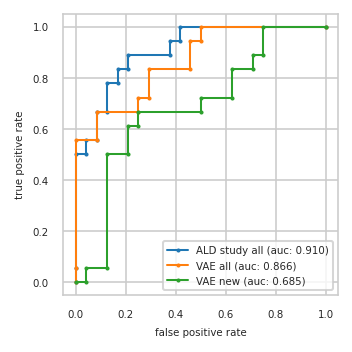

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.500   0.000 0.556   0.042 0.056
3          0.042 0.500   0.083 0.556   0.125 0.056
4          0.042 0.556   0.083 0.667   0.125 0.500
5          0.083 0.556   0.250 0.667   0.208 0.500
6          0.083 0.667   0.250 0.722   0.208 0.611
7          0.125 0.667   0.292 0.722   0.250 0.611
8          0.125 0.778   0.292 0.833   0.250 0.667
9          0.167 0.778   0.458 0.833   0.500 0.667
10         0.167 0.833   0.458 0.944   0.500 0.722
11         0.208 0.833   0.500 0.944   0.625 0.722
12         0.208 0.889   0.500 1.000   0.625 0.833
13         0.375 0.889   1.000 1.000   0.708 0.833
14         0.375 0.944     NaN   NaN   0.708 0.889
15         0.417 0.944     NaN   NaN   0.750 0.889
16         0.417 1.000     NaN   NaN   0.750 1.000
17         1.000 1.000     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q8NCL4,Q92765,Q8WYK1
2,A0A1B0GV23;A0A1B0GVD5;A0A1B0GWE8;P07339,Q96GD0,P04040
3,P61981,P04075,Q9NUQ9
4,P14174,Q9Y2T3;Q9Y2T3-3,P31321
5,P04075,P61981,J3KSJ8;Q9UD71;Q9UD71-2
6,P00338;P00338-3,P14174,O95497
7,Q9Y2T3;Q9Y2T3-3,P15151-2,Q96GD0
8,P18428,P63104,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


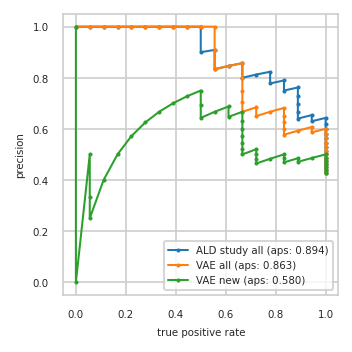

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.581 1.000     0.581 1.000     0.484 0.833
12         0.600 1.000     0.600 1.000     0.500 0.833
13         0.621 1.000     0.586 0.944     0.483 0.778
14         0.643 1.000     0.607 0.944     0.464 0.722
15         0.630 0.944     0.593 0.889     0.481 0.722
16         0.654 0.944     0.577 0.833     0.500 0.722
17         0.640 0.889     0.600 0.833     0.520 0.722
18         0.667 0.889     0.625 0.833     0.500 0.667
19         0.696 0.889     0.652 0.833     0.522 0.667
20         0.727 0.889     0.682 0.833     0.545 0.667
21         0.762 0.889     0.667 0.778     0.571 0.667
22         0.750 0.833     0.650 0.722     0.600 0.667
23         0.789 0.833     0.684 0.722     0.632 0.667
24         0.778 0.778     0.667 0.667     0.667 0.667
25         0.824 0.778     0.706 0.667     0.647 0.611
26         0.812 0.722     0.750 0.667     0.688 0.611
27         0.800 0.667     0.800 0.667     0.667 0.556
28         0.857 0.667     0.857 0.667     0.643 0.500
29         0.846 0.611     0.846 0.611     0.692 0.500
30         0.833 0.556     0.833 0.556     0.750 0.500
31         0.909 0.556     0.909 0.556     0.727 0.444
32         0.900 0.500     1.000 0.556     0.700 0.389
33         1.000 0.500     1.000 0.500     0.667 0.333
34         1.000 0.444     1.000 0.444     0.625 0.278
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.250 0.056
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


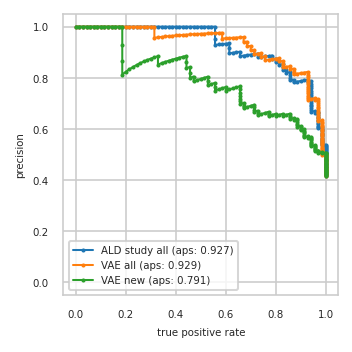

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


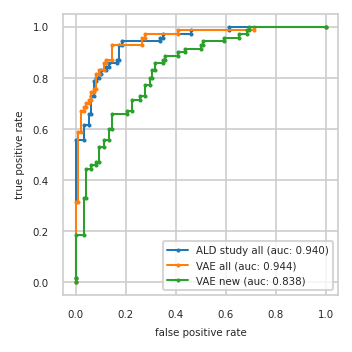

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}